## Week 02 (Monday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Exercise 1

In [1]:
# we use the numpy scipy and friends stack so much that it's worth just having things in the namespace
# you can do that with %pylab here
# The things that start with % are called `magics`
# There's a lot of them, and you can see the list here: 
# https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


Download this file (too big for git!)
https://bit.ly/38PDnGy

Use h5py to look at this data - h5py.File() to open, and then use the keys() method to find what elements are store.

Use matplotlib to visualize this point cloud (CAREFUL)

Use pandas to convert the first two columns of the numpy array to a dataframe

Use seaborn’s jointplot to visualize this dataframe (try hex, or a kde with every 100th sample)

In [2]:
# HDF5 is a structured file format popular for large datasets
# originally developed here, at NCSA, it's the de facto standard
# for large binary datasets that have to be portable between
# different programming languages. 
# https://en.wikipedia.org/wiki/Hierarchical_Data_Format

import h5py

In [3]:
# while most libraries that open files use a function named 
# `open`, h5py uses "File" instead

data = h5py.File('sdssj120650-20130310-total_mcmc.hdf5')

In [4]:
# you can look at the elements inside a HDF5 file with keys()
data.keys()

<KeysViewHDF5 ['chain', 'params']>

In class I didn't really provide context for what the data was because it wasn't relevant to the exercise. Let's spend a little more time looking at it though.

In [5]:
# let's look at the chain group
data['chain']

<HDF5 group "/chain" (5 members)>

In [6]:
# that group itself has multiple keys
data['chain'].keys()

<KeysViewHDF5 ['afrac', 'lnprob', 'names', 'position', 'tswap_afrac']>

In [7]:
# So chain itself has a bunch of datasets
# Let's look at names
data['chain']['names']

<HDF5 dataset "names": shape (9,), type "|S4">

In [8]:
# This looks like something else - it has no nested keys but instead says it's a dataset with length 9
# The datatype suggests that it holds strings with a maximum length of 4
# We can cast this to a numpy array 
names = np.array(data['chain']['names'])
names

array([b'teff', b'logg', b'av', b'dl', b'fwhm', b'fsig', b'tau', b'fw',
       b'mu'], dtype='|S4')

In [9]:
# ok, so we have something that looks like parameter names - the b denotes that they are "byte-strings"
# to translate them into regular strings you have to supply an encoding
# the encoding specifies how the bytes are to be converted into a regular string
# the default is unicode or UTF-8, but there's plenty of encodings - ascii, cyrillic, hindi...

names = [x.decode('utf-8') for x in names]


# let's look at the position item next
data['chain']['position']

<HDF5 dataset "position": shape (2000000, 9), type "<f4">

In [10]:
# this looks like another dataset - the shape this time is 2 million rows X 9 columns with floating point numbers
# presumably the 9 columns correspond to the 9 names
# lets get this as an array as well
pos = np.array(data['chain']['position'])

In [11]:
# let's just look at the first row
pos[0]

array([2.1631852e+04, 7.8012624e+00, 9.9401720e-02, 3.4938181e+03,
       4.7777710e+00, 6.3605392e-01, 5.1781841e+03, 6.3061573e-02,
       5.7964489e+01], dtype=float32)

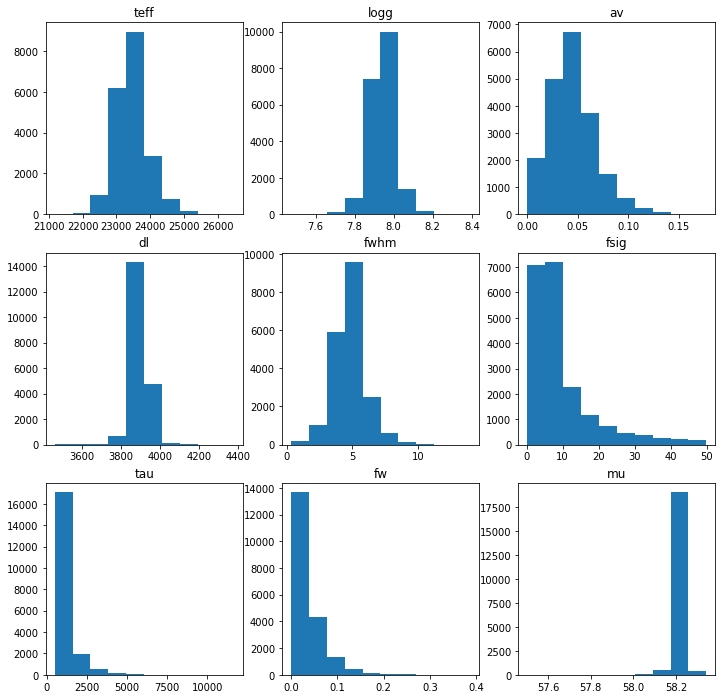

In [12]:
# OK - we can visualize this dataframe in a few different ways
# before we use matplotlib to look at the bivariate distributions, lets look at the univariate distributions
fig = plt.figure(figsize=(12, 12))

# we can loop over each column - the column indices are the same as the indices in names
for i, name in enumerate(names):
    # let's create a new axes for each plot
    # the format is total number of rows, total number of columns, current index starting with 1
    ax = fig.add_subplot(3, 3, i+1)
    
    # we don't need all 2 million samples to get some idea of the distribution
    # lets downsample by picking every 100th
    # the slicing for numpy arrays works as [start:stop:step]
    # if we don't specify start and stop, the defaults are 0 and -1 (the first and last elements)
    # we can just write that as [::step]
    ax.hist(pos[:,i][::100])
    ax.set_title(name)


In [13]:
# so several different distributions with very different shapes 
# and not all of them are symmetric even

# we'll just plot the first two columns for now
# and use the same downsampling by a factor of 100 to reduce the volume of data we're looking at

x = pos[:,0][::100]
y = pos[:,1][::100]

Text(0, 0.5, 'logg')

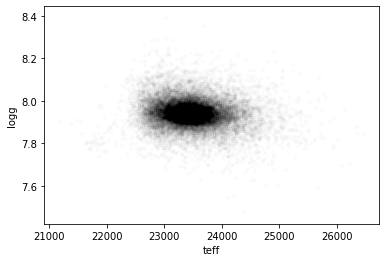

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, marker='.', color='k', alpha=0.01)
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])

In [15]:
# not bad, but the center of this multivariate data is still hard to get a sense for
# let's use seaborn's jointplot which is specifically designed for the job of looking at bivariate data

import seaborn as sns

In [16]:
# we could just pass the vectors we saved to jointplot, but we downsampled them by a factor of 100
# seaborn won't have a problem with the large number of points if we're plotting a 2D histogram
# so lets use pandas to get all the data into seaborn as a dataframe

import pandas as pd
df = pd.DataFrame(pos[:,0:2], columns=[names[0],names[1]])

In [17]:
# let's make sure the dataframe has everything
df

teff      logg
0        21631.851562  7.801262
1        21591.556641  7.804831
2        21779.921875  7.803291
3        21700.144531  7.788880
4        21863.031250  7.854690
...               ...       ...
1999995  23887.169922  8.187648
1999996  24596.712891  7.885874
1999997  23540.755859  8.144714
1999998  25513.160156  7.833400
1999999  23476.443359  7.969227

[2000000 rows x 2 columns]

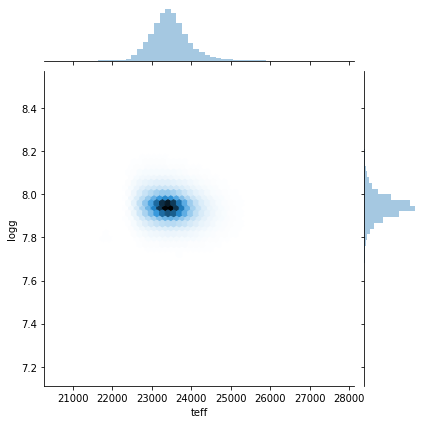

In [18]:
sns.jointplot(x='teff', y='logg', data=df, kind='hex')

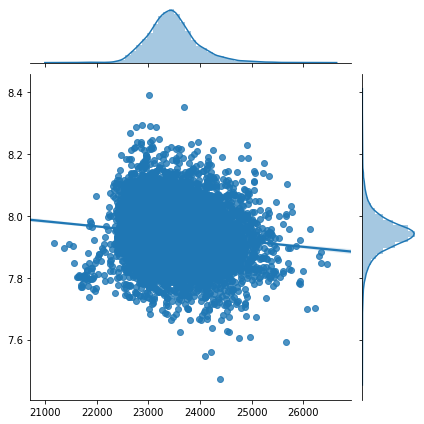

In [19]:
# Cool - we're not just getting a density plot, we're getting a 1D marginalization along both axes
# all with less work than matplotlib
# there's many ways to do things, but some ways are easier/apparently better than others

# we can also have seaborn just plot the vectors directly and do things like regression
sns.jointplot(x=x, y=y, kind='reg')

Hmm - the regression doesn't really look very good - there's some covariance between the two parameters but it's fairly weak - there's another way to get a sense of density. Look at this topographic map. Here' we're using contours to indicate density.

<img src="https://sitesmedia.s3.amazonaws.com/creekconnections/files/2014/09/topomap.jpg">

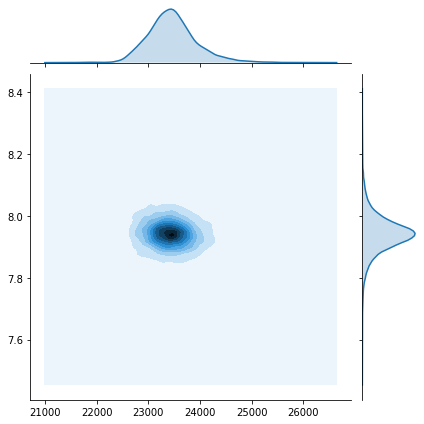

In [20]:
# seaborn can produce the same sort of output 
# using a technique called a kernel density estimate that we'll learn about soon

sns.jointplot(x=x, y=y, kind='kde')

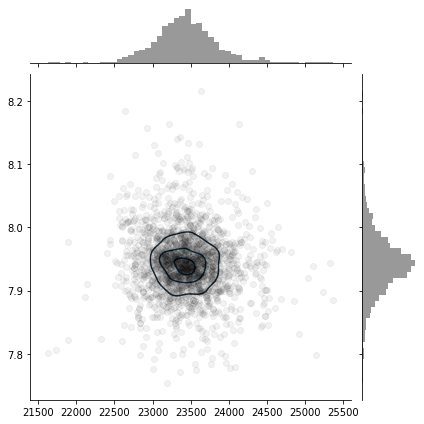

In [21]:
# you can even combine scatter plots and contours together with seaborn
sns.jointplot(x=x[::10], y=y[::10], color='k', alpha=0.05).plot_joint(sns.kdeplot, zorder=0, n_levels=3)

In [22]:
# Of course, we only dealt with bivariate data in class
# this was multivariate data
# if you want to visualize all of it, there's other dedicated tools
# this will let you make what is called a corner plot - a sequence of joint plots for visualizing multivariate data
import corner

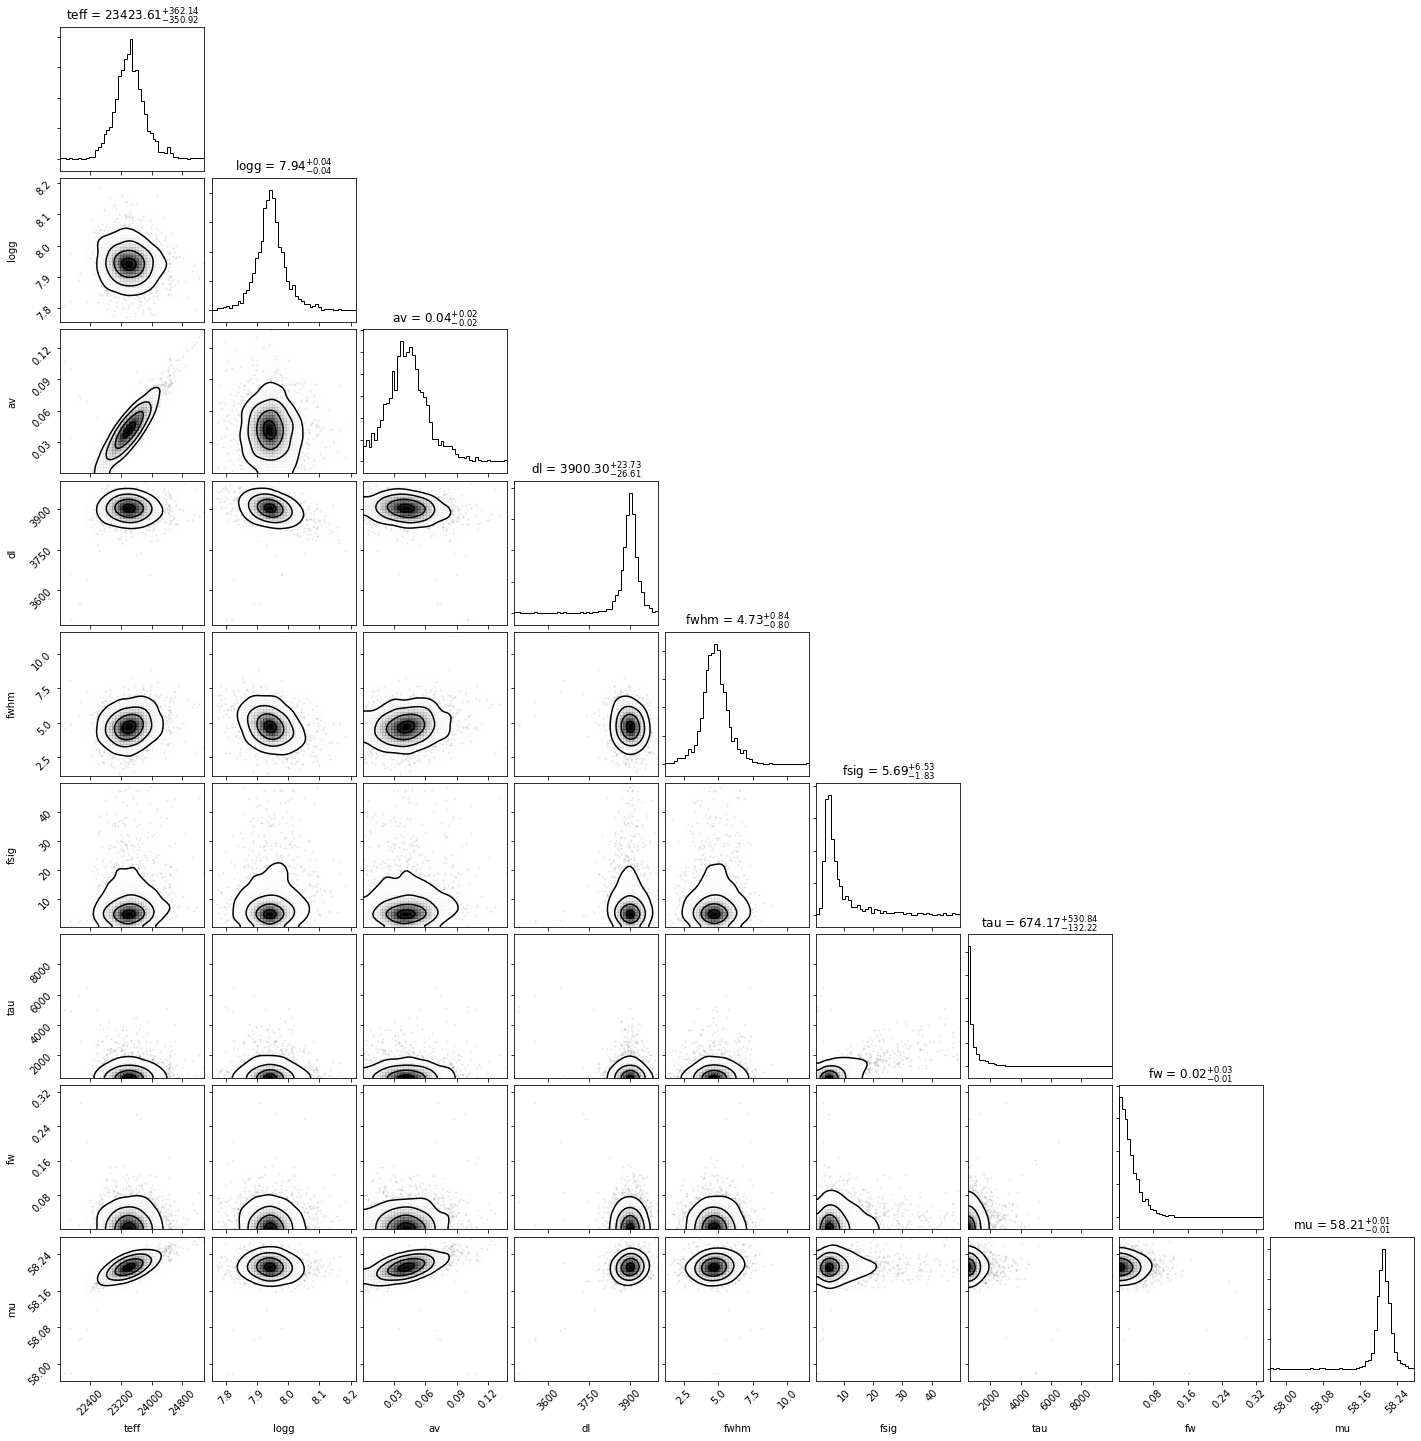

In [23]:
fig = corner.corner(pos[::1000,:], bins=50, color='k', smooth=2, labels=names, show_titles=True, scale_hist=True)
show(fig)

You are well armed to tackle visualizing any multivariate datasets this semester, and hopefully have a sense for marginalizations (the 1D histograms) as well. 

### Exercise 2

Remember that what we want is *P(H|D)* 

In Exercise 1 we were using the data, and implictly trying to derive an empirical distribution function from the sample.
But what we want is not the empirical distribution function of the data, but knowledge of the underying probability distribution from which the data itself were drawn. 

The framework of Bayes' theorem gives us a way to do this using the posteriod *P(H|D)* 
But to do that, we need a *H*
Generally, this hypotheses will come from some physical information about the system being considered.
Often, hypotheses are simplifications/approximations, but they still give us some purchase to learn about our Universe.

This is summed up in a nice aphorism, attributed to George Box: 
### "All models are wrong but some are useful."

What we're doing here is seeing if we can describe data with a useful model.


---


We'll use the same dataset we used in part 2. 

You estimated the means in both x and y by eye, but now estimate the standard deviations by eye as well.

Use scipy.stats.multi_variate normal to construct a distribution object in python and overlay it with matplotlib (https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html)


Finally, see how well your eyeball estimate matches astroML.stats.fit_bivariate_normal

In [2]:
import h5py
import seaborn as sns
import pandas as pd

In [3]:
data = h5py.File('sdssj120650-20130310-total_mcmc.hdf5')
names = np.array(data['chain']['names'])
names = [x.decode('utf-8') for x in names]
pos = np.array(data['chain']['position'])
df = pd.DataFrame(pos[:,0:2], columns=[names[0],names[1]])

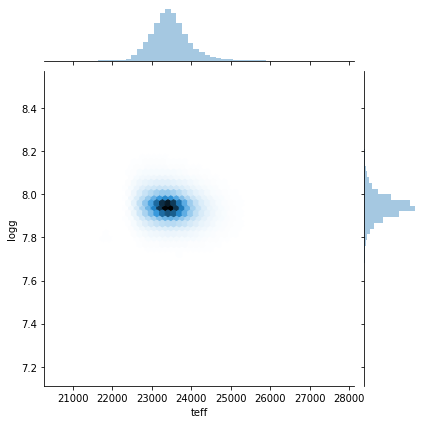

In [4]:
sns.jointplot(x='teff', y='logg', data=df, kind='hex')

In [5]:
# Based on our discussions in class, you estimated these means and standard deviations
# we'll use these to construct a multivariate (well bivariate here) normal distribution
# That distribution will be our model of the data.

mu_x = 23500.
mu_y = 7.9
sigma_x = 500.
sigma_y = 0.1

The multivariate normal looks very much like the 1D normal distribution, but with scalar X replaced by a vector in N-D imensions and the covariance replaced by a NxN matrix. The off-diagonal elements of this matrix represent the correlation between the dimensions - which for now we're going to assume is 0. Wrong but useful.

In [6]:
from scipy.stats import multivariate_normal

In [7]:
# first we should define a grid of points and spacing along each axis 
# on which we evaluate the multivariate normal PDF

# we can just read those of the plot above or from part 2
# we construct the grid with the numpy "meshgrid function"
# remember the array indexing notation is start:stop:stepsize
x, y = np.mgrid[21000:27000:300, 7.5:8.4:0.05]

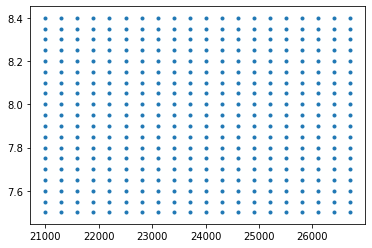

In [8]:
# we can visualize the grid easily
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, marker='.')

In [9]:
# this is grid of points on which we will evaluate the PDF, but we also need to store the actual p(x, y) values
# we can do that by constructing an empty array and adding an axis to store the z = p(x, y) values

pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

In [10]:
# now we need to construct our mean vector and covariance matrix
# remember that the variance is the square of the standard deviations you estimated

mu = [mu_x, mu_y]
covmat = [[sigma_x**2., 0.], [0., sigma_y**2]]

In [11]:
# we now have to initalize a multivariate normal object for our specific values of mu and sigma
rv = multivariate_normal(mu, covmat)

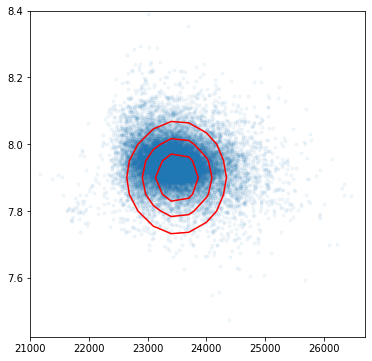

In [12]:
# ok, lets see if this model is a reasonable description of the data

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(df['teff'][::100], df['logg'][::100], marker='.', alpha=0.05)
ax.contour(x, y, rv.pdf(pos), levels=3, colors='r')

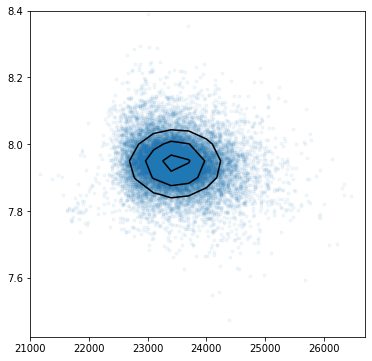

In [13]:
# we can do better by using the mean and standard deviation estimated from the data
# this is called the method of moments

mu_x = np.mean(df['teff'][::100])
mu_y = np.mean(df['logg'][::100])
sigma_x = np.std(df['teff'][::100])
sigma_y = np.std(df['logg'][::100])

mu = [mu_x, mu_y]
covmat = [[sigma_x**2., 0.], [0., sigma_y**2]]
rv = multivariate_normal(mu, covmat)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(df['teff'][::100], df['logg'][::100], marker='.', alpha=0.05)
ax.contour(x, y, rv.pdf(pos), levels=3, colors='k')

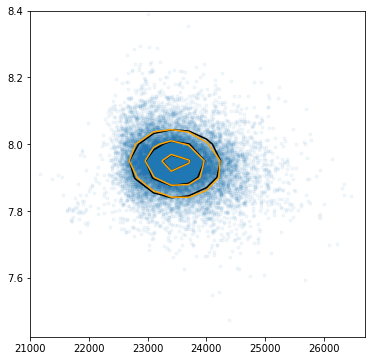

In [14]:
# that's better! We can refine even further if we use the covariance from the data

mu_x = np.mean(df['teff'][::100])
mu_y = np.mean(df['logg'][::100])
covmat = df[::100].cov()

rv2 = multivariate_normal(mu, covmat)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(df['teff'][::100], df['logg'][::100], marker='.', alpha=0.05)
ax.contour(x, y, rv.pdf(pos), levels=3, colors='k')
ax.contour(x, y, rv2.pdf(pos), levels=3, colors='orange')

In [15]:
# now we've used this to model bivariate data, but the procedure is general
# you can use it for any N-D dataset
# in the case of bivariate data, this is a nice convenience function that gives you 

from astroML.stats import fit_bivariate_normal

In [16]:
fitted_mu, fit_sig_x, fit_sig_y, theta = fit_bivariate_normal(df['teff'][::100], df['logg'][::100])

In [17]:
# compare what you get from the data:
print(mu, fitted_mu)

[23469.822265625, 7.941982746124268] [23469.834, 7.9419694]


In [18]:
print(sigma_x, fit_sig_x)
print(sigma_y, fit_sig_y)

483.25286865234375 483.25180060307747
0.06335979700088501 0.06285469773799178


The fitted mean, assuming a normal distribution and the sample mean are close, as are the fitted standard deviation and estimated standard deviation.

This is good but not unexpected because visibly the data looked reasonably consistent with a bivariate normal. This model was useful.

The converse is NOT true. 

If the moments of two distributions agree, that does not always mean that the distributions are in good agreement as we'll see in the next exercise.